In [8]:
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *

In [17]:
%matplotlib inline
# to plot figures correctly

In [14]:
# functions from lesson_functions.py
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
						vis=False, feature_vec=True):
	# Call with two outputs if vis==True
	if vis == True:
		features, hog_image = hog(img, orientations=orient,
								  pixels_per_cell=(pix_per_cell, pix_per_cell),
								  cells_per_block=(cell_per_block, cell_per_block),
								  transform_sqrt=True,
								  visualise=vis, feature_vector=feature_vec)
		return features, hog_image
	# Otherwise call with one output
	else:
		features = hog(img, orientations=orient,
					   pixels_per_cell=(pix_per_cell, pix_per_cell),
					   cells_per_block=(cell_per_block, cell_per_block),
					   transform_sqrt=True,
					   visualise=vis, feature_vector=feature_vec)
		return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
	# Use cv2.resize().ravel() to create the feature vector
	features = cv2.resize(img, size).ravel()
	# Return the feature vector
	return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):#, bins_range=(0, 256)):
	# Compute the histogram of the color channels separately
	channel1_hist = np.histogram(img[:,:,0], bins=nbins)#, range=bins_range)
	channel2_hist = np.histogram(img[:,:,1], bins=nbins)#, range=bins_range)
	channel3_hist = np.histogram(img[:,:,2], bins=nbins)#, range=bins_range)
	# Concatenate the histograms into a single feature vector
	hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
	# Return the individual histograms, bin_centers and feature vector
	return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
						hist_bins=32, orient=9,
						pix_per_cell=8, cell_per_block=2, hog_channel=0,
						spatial_feat=True, hist_feat=True, hog_feat=True):
	# Create a list to append feature vectors to
	features = []
	# Iterate through the list of images
	for file in imgs:
		file_features = []
		# Read in each one by one
		image = mpimg.imread(file)
		# apply color conversion if other than 'RGB'
		if color_space != 'RGB':
			if color_space == 'HSV':
				feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
			elif color_space == 'LUV':
				feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
			elif color_space == 'HLS':
				feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
			elif color_space == 'YUV':
				feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
			elif color_space == 'YCrCb':
				feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
		else: feature_image = np.copy(image)

		if spatial_feat == True:
			spatial_features = bin_spatial(feature_image, size=spatial_size)
			file_features.append(spatial_features)
		if hist_feat == True:
			# Apply color_hist()
			hist_features = color_hist(feature_image, nbins=hist_bins)
			file_features.append(hist_features)
		if hog_feat == True:
		# Call get_hog_features() with vis=False, feature_vec=True
			if hog_channel == 'ALL':
				hog_features = []
				for channel in range(feature_image.shape[2]):
					hog_features.append(get_hog_features(feature_image[:,:,channel],
										orient, pix_per_cell, cell_per_block,
										vis=False, feature_vec=True))
				hog_features = np.ravel(hog_features)
			else:
				hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
							pix_per_cell, cell_per_block, vis=False, feature_vec=True)
			# Append the new feature vector to the features list
			file_features.append(hog_features)
		features.append(np.concatenate(file_features))
	# Return list of feature vectors
	return features

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
					xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
	# If x and/or y start/stop positions not defined, set to image size
	if x_start_stop[0] == None:
		x_start_stop[0] = 0
	if x_start_stop[1] == None:
		x_start_stop[1] = img.shape[1]
	if y_start_stop[0] == None:
		y_start_stop[0] = 0
	if y_start_stop[1] == None:
		y_start_stop[1] = img.shape[0]
	# Compute the span of the region to be searched
	xspan = x_start_stop[1] - x_start_stop[0]
	yspan = y_start_stop[1] - y_start_stop[0]
	# Compute the number of pixels per step in x/y
	nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
	ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
	# Compute the number of windows in x/y
	nx_windows = np.int(xspan/nx_pix_per_step) - 1
	ny_windows = np.int(yspan/ny_pix_per_step) - 1
	# Initialize a list to append window positions to
	window_list = []
	# Loop through finding x and y window positions
	# Note: you could vectorize this step, but in practice
	# you'll be considering windows one by one with your
	# classifier, so looping makes sense
	for ys in range(ny_windows):
		for xs in range(nx_windows):
			# Calculate window position
			startx = xs*nx_pix_per_step + x_start_stop[0]
			endx = startx + xy_window[0]
			starty = ys*ny_pix_per_step + y_start_stop[0]
			endy = starty + xy_window[1]

			# Append window position to list
			window_list.append(((startx, starty), (endx, endy)))
	# Return the list of windows
	return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
	# Make a copy of the image
	imcopy = np.copy(img)
	# Iterate through the bounding boxes
	for bbox in bboxes:
		# Draw a rectangle given bbox coordinates
		cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
	# Return the image copy with boxes drawn
	return imcopy
# plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
	for i, img in enumerate(imgs):
		plt.subplot(rows, cols, i+1)
		plt.title(i+1)
		img_dims = len(img.shape)
		if img_dims < 3:
			plt.imshow(img, cmap='hot')
			plt.title(titles[i])
		else:
			plt.imshow(img)
			plt.title(titles[i])

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.41 Seconds to train SVC...
Test Accuracy of SVC =  0.997


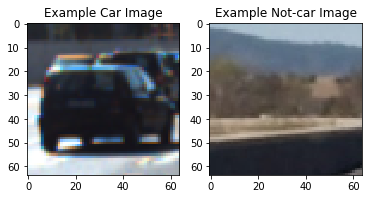

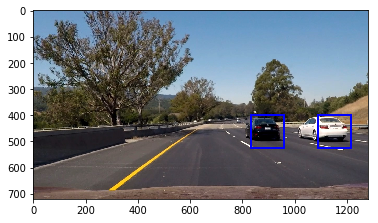

In [18]:
'''This is where I read the data, You need to change the directory of the png files.'''
# Read in cars and notcars
baseDir = 'C:\\Users\\Qiang\\Downloads\\SDC\\non-vehicles\\'
# Non cars 
images = glob.glob(baseDir + 'Extras\\*.png')
images += glob.glob(baseDir + 'GTI\\*.png')

cars = []
notcars = []
for image in images:
    notcars.append(image)

baseDir = 'C:\\Users\\Qiang\\Downloads\\SDC\\non-vehicles\\'

images_car = glob.glob(baseDir + 'KITTI_Extracted\\*.png')
images_car = glob.glob(baseDir + 'GTI_Far\\*.png')
images_car = glob.glob(baseDir + 'GTI_Left\\*.png')
images_car = glob.glob(baseDir + 'GTI_MiddleClose\\*.png')
images_car = glob.glob(baseDir + 'GTI_Right\\*.png')
for image in images_car:
    cars.append(image)
        
''' Print original Data: plot car and non car images'''
# Just for fun choose random car / not-car indices and plot example images
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


# Reduce the sample size because
# # The quiz evaluator times out after 13s of CPU time
sample_size = min(len(cars), len(notcars))
# print(sample_size, len(cars), len(notcars))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]




In [ ]:

# Parameters
color_space =  'YCrCb'#'RGB'#''HSV'#'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

########## Train the classifier using HOG features and color features.
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

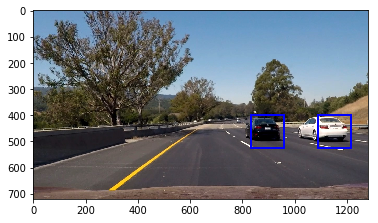

In [19]:
'''test case'''
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(128, 128), xy_overlap=(0.5, 0.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)


y_start_stop = [360, 720]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(96 * 3, 96 * 2), xy_overlap=(0.5, 0.5))

hot_windows1 = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

y_start_stop = [360, 720]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(96 * 3, 96 * 3), xy_overlap=(0.5, 0.5))

hot_windows2 = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

hot_windows = hot_windows + hot_windows1 + hot_windows2
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.figure()
plt.imshow(window_img)
plt.show()


0.0 1.0
0.2880287170410156 seconds to process one image searching 57 windows
0.0 1.0
0.29602980613708496 seconds to process one image searching 57 windows
0.0 1.0
0.2820281982421875 seconds to process one image searching 57 windows
0.0 1.0
0.2800278663635254 seconds to process one image searching 57 windows
0.0 1.0
0.27402734756469727 seconds to process one image searching 57 windows
0.0 1.0
0.28502845764160156 seconds to process one image searching 57 windows


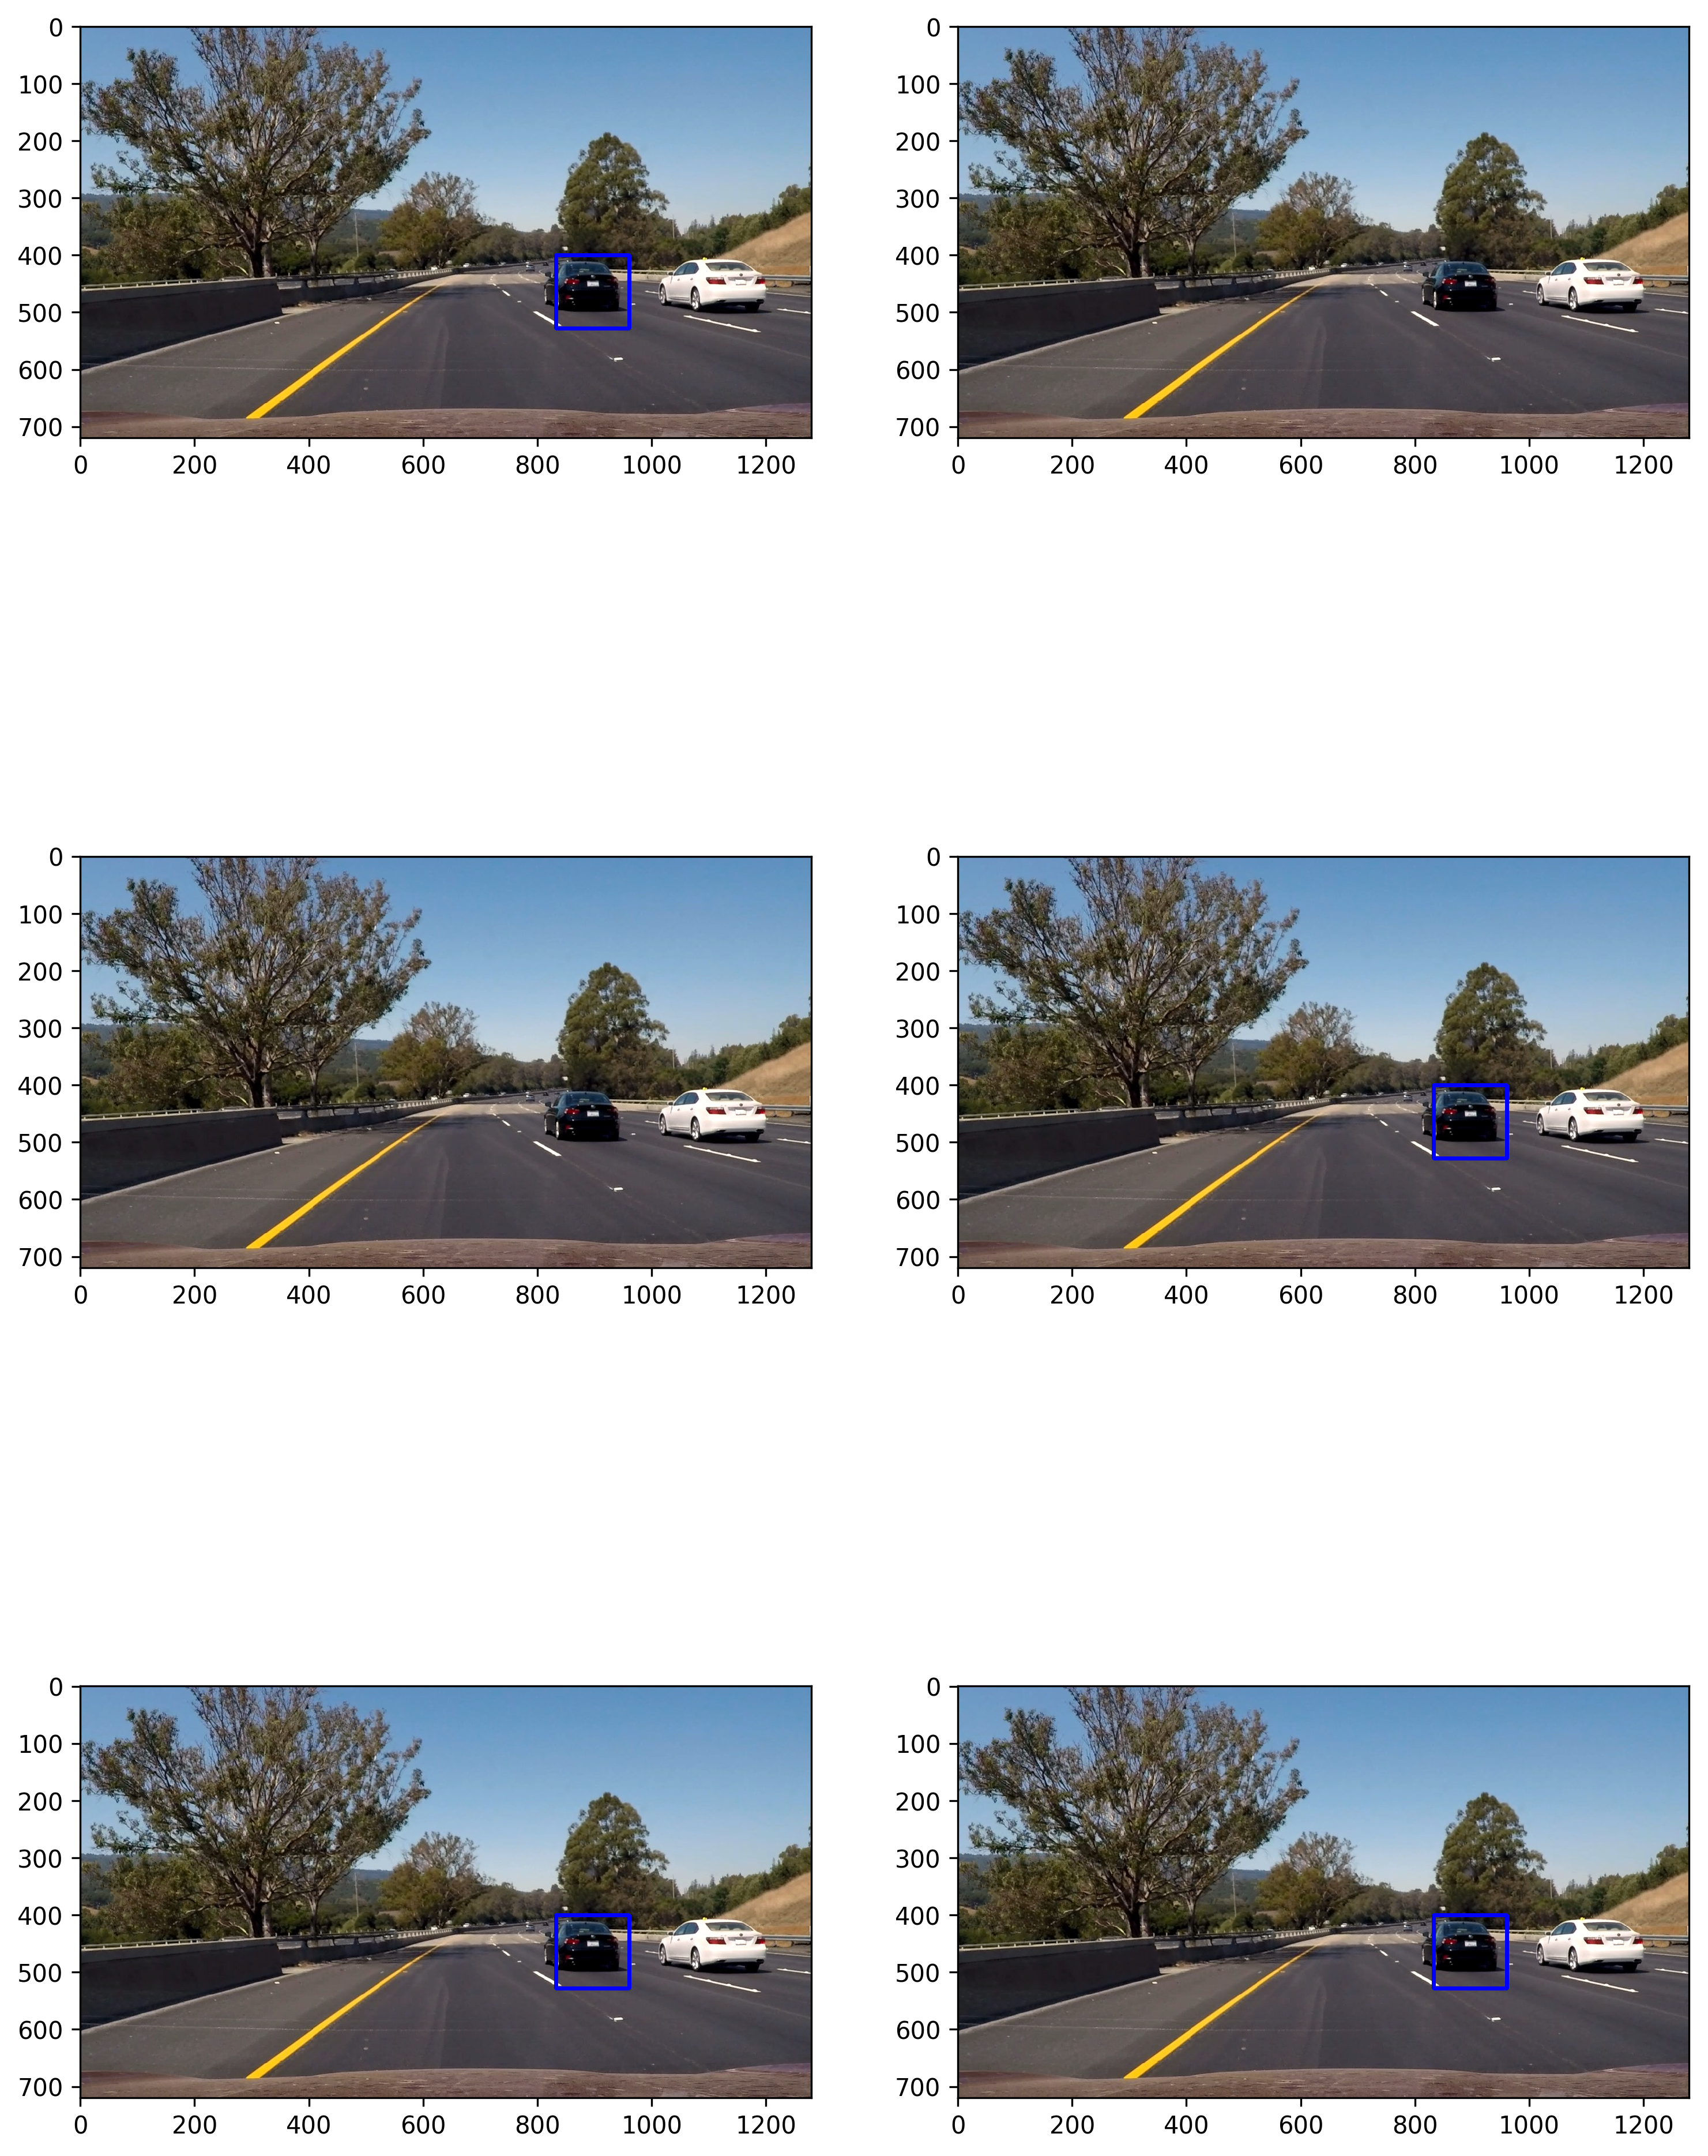

In [21]:
searchPath = 'test_images/*.jpg'
example_images = glob.glob(searchPath)
images = []
titles = []
y_start_stop = [400, 656] # min and max position of y to search
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(128, 128), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
    
fig = plt.figure(figsize=(12, 18), dpi = 300)
visualize(fig, 3, 2, images, titles)

In [22]:
# convert color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

1.611161231994629 seconds to run, total windows = 294
0.3320333957672119 seconds to run, total windows = 294
0.32003211975097656 seconds to run, total windows = 294
0.4110410213470459 seconds to run, total windows = 294
0.45404553413391113 seconds to run, total windows = 294
0.48204803466796875 seconds to run, total windows = 294


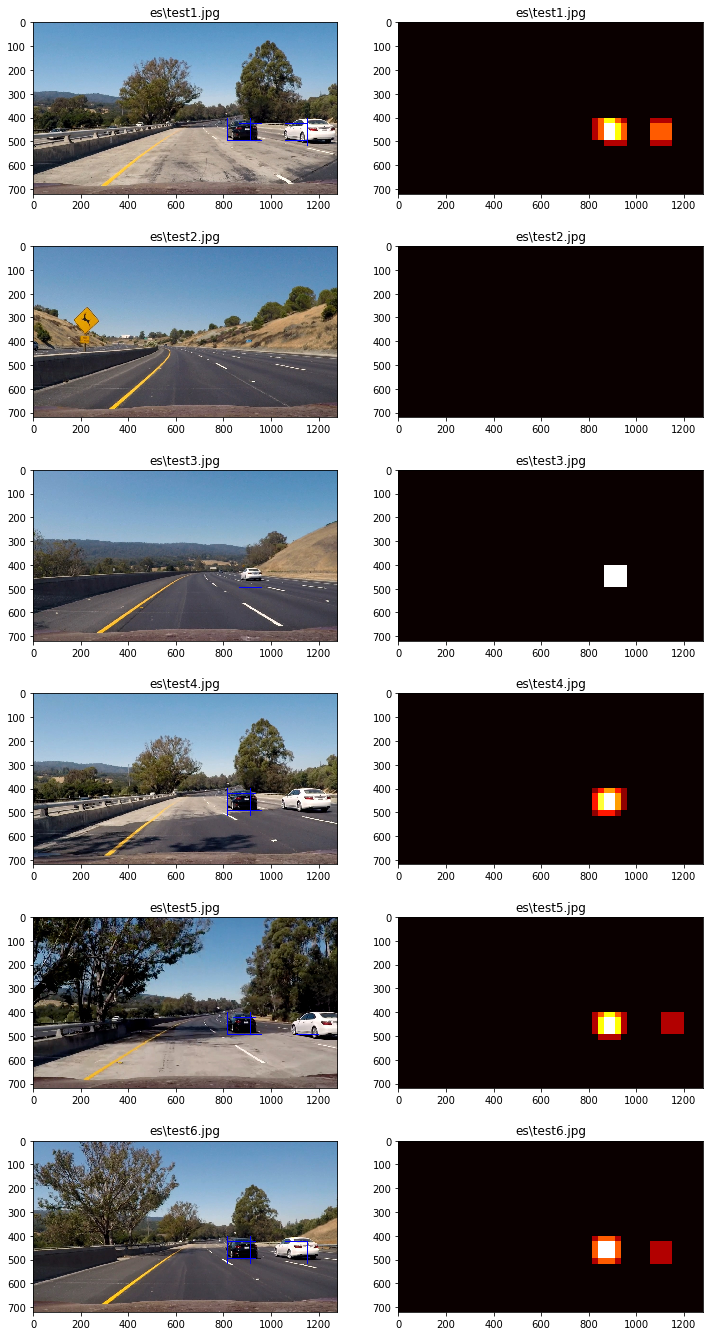

In [23]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5

#iterate over test images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    #make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop, :, :]
    # color transformed image
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # rather than consider different window size, resize the image here
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # define blocks and steps above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 #instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            # concatenate all features into 1
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))).reshape(1, -1)
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+ystart+win_draw, xbox_left:xbox_left+win_draw] +=1
                
    print(time.time()-t, 'seconds to run, total windows =', count)
    
    out_images.append(draw_img)
    # append the name twice, since two processed images
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
    
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=[12,24])
visualize(fig, 6, 2, out_images, out_titles)
   

In [27]:
# iterate over test images
def find_cars(img, scale):
    draw_img = np.copy(img)
    #make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop, :, :]
    # color transformed image
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # rather than consider different window size, resize the image here
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # define blocks and steps above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 #instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            # concatenate all features into 1
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))).reshape(1, -1)
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+ystart+win_draw, xbox_left:xbox_left+win_draw] +=1
                
    return draw_img, heatmap
    

In [28]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


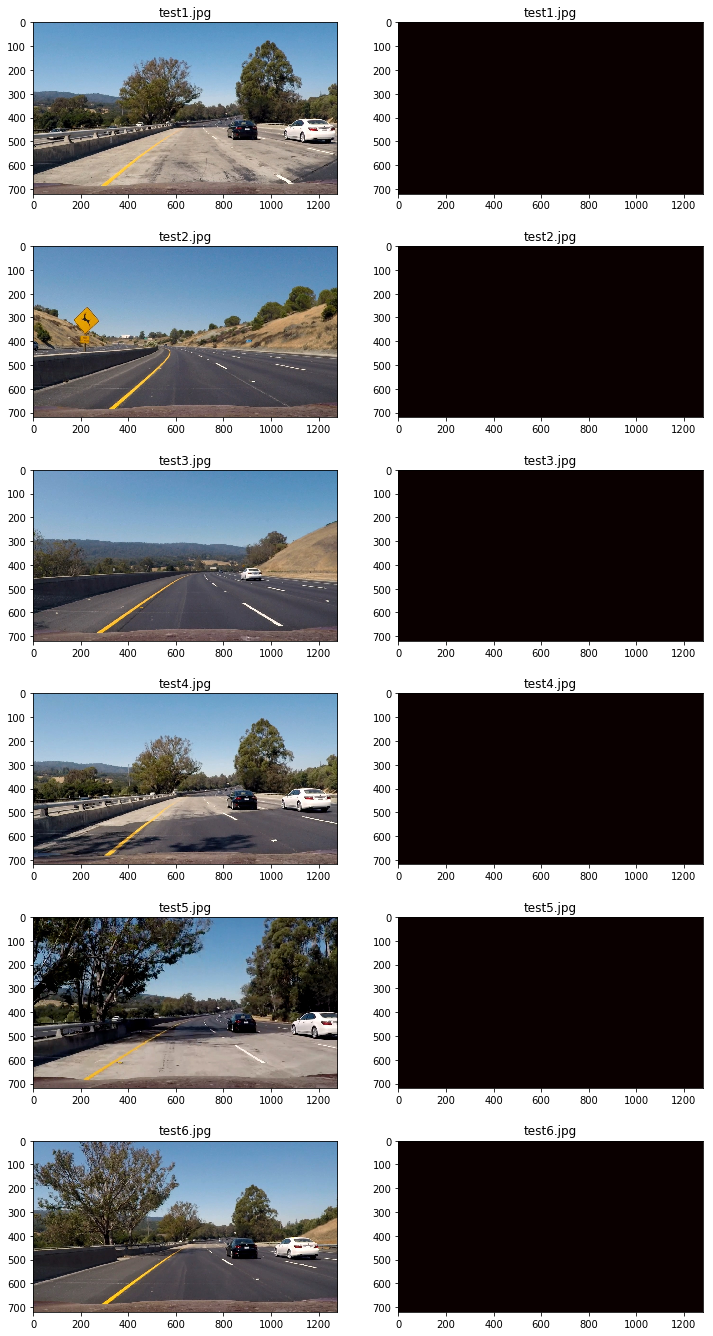

In [36]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5
#iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heatmap = find_cars(img, scale)
    
    heatmap = apply_threshold(heatmap, 2)
    
    labels = label(heatmap)
    # draw boudning boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heatmap)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])

fig = plt.figure(figsize=[12,24])
visualize(fig, 6, 2, out_images, out_titles)

In [33]:
def process_image(img):
    out_img, heatmap = find_cars(img, scale)
    labels = label(heatmap)
    # draw bouding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
# test_output = 'project.mp4'
clip = VideoFileClip('test_video.mp4')

# clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)

  self.nchannels))

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  0%|                                                   | 0/39 [00:00<?, ?it/s]WARNING:py.warnings:C:\Users\Qiang\Anaconda2\envs\carnd-term1\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)

  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [ ]:
# define a class 
